# Concept test
## VarClump1D

In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
import matplotlib.pyplot as plt
from scipy import interpolate, optimize

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

## Helper functions

In [2]:
"""
Helper function to visualize the quality of the solution
"""
def compare_plot(c, sig, xc, resolution=10, title=None):
    _xe = np.linspace(0., 1., 10*N, endpoint=True)
    _Dx = np.empty((10*N,N))
    for k in range(10*N):
        _Dx[k,:] = (_xe[k] - xc)

    phi_m = phi(_Dx, sig)
    u = np.dot(phi_m, c)
    plt.figure(figsize=(10,6))
    plt.plot(_xe, u, 'r-', label='Solution')
    plt.plot(x_, f(x_), 'b--', label='Data')
    plt.plot(xe, f(xe), 'go', label='Evaluation points')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.show()

## Variational Model

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, u, u_x) \ dx  = \int_{\Omega \subset \mathbb{R}}(u(x)-f_0(x))^2 + \alpha \ \Psi_1(u(x)-f_0(x)) + \beta \ \Psi_2(|u_x(x)|) \ dx $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} =  2(u(x)-f_0(x)) + \alpha \ \Psi_1'(u(x)-f_0(x)) - \beta \ u_{xx}(x) \ \Psi_2''(|u_{x}(x)|) = 0$$

whit boundary condition $u(\partial \Omega) = 0$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x) = \sum_{i=1}^N c_i \ \phi(x; x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2}{2 \sigma_i^2}}$$

In [3]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
cont.load('../../bindata/fits/cubes/M100line.image.fits')
#cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.data

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]

In [4]:
"""
Generating the data function
"""
f_data = data[:,300,300]
f_data /= np.max(f_data)
x = np.linspace(0., 1., len(f_data), endpoint=True)
f = sp.interpolate.interp1d(x, f_data, kind='linear')
x_ = np.linspace(0., 1., 10*len(f_data), endpoint=True)

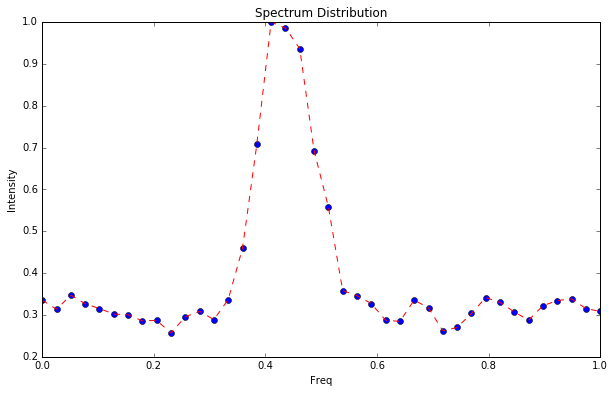

In [5]:
plt.figure(figsize=(10,6))
plt.plot(x, f_data, 'bo', x_, f(x_), 'r--')
plt.title('Spectrum Distribution')
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.show()

$$\frac{4 (x-1) x+2}{4 (x-1)^2 x^2 \left(\cosh \left(\frac{1}{x}+\frac{1}{x-1}\right)+1\right)}$$

In [6]:
#setting parameters
a = 0.1
b = 0.1*0
N = 10

z = sym.Symbol('z')

#Penalizing function and its derivatives
#psi1 = sym.exp(z)
#d1psi1 = sym.diff(psi1, z)
#d1psi1 = sym.lambdify(z, d1psi1, modules='numpy')
def d1psi1(x):
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 1.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('(4*(x-1)*x+2) / (4*(x-1)**2 * x**2 * (cosh(1/x + 1/(x-1))+1))')
    return ret
    

#Smoothing function and its derivatives
lamb = 0.5
#psi2 = 2*lamb*sym.log(1 + z**2/lamb)
psi2 = z**3
d1psi2 = sym.diff(psi2, z)
d2psi2 = sym.diff(d1psi2, z)
d1psi2 = sym.lambdify(z, d1psi2, modules='numpy')
d2psi2 = sym.lambdify(z, d2psi2, modules='numpy')

In [7]:
"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, sig):
    #retval = ne.evaluate('exp(-x**2/(2*sig**2))')
    retval = np.exp(-x**2/(2*sig**2))
    return retval

def phix(x, sig):
    #retval = ne.evaluate('-(1./sig**2) * exp(-x**2/(2*sig**2)) * x')
    retval = -(1./sig**2) * np.exp(-x**2/(2*sig**2)) * x
    return retval

def phixx(x, sig):
    #retval = ne.evaluate('(1./sig**4) * exp(-x**2/(2*sig**2)) * (x**2 - sig**2)')
    retval = (1./sig**4) * np.exp(-x**2/(2*sig**2)) * (x**2 - sig**2)
    #retval =  (x**2 - sig**2)
    #print(np.sort((np.abs(x)).ravel()))
    return retval

In [8]:
class ELFunc():
    def __init__(self, f0, c0, sig0, xc, Dx):
        len_c0 = len(c0)
        len_sig0 = len(sig0)
        shape_Dx = Dx.shape
        #if len_c0 != len_sig0: 
        #    print('Dimensions of c0 and sig0 must match!')
        #    return None
        #if (shape_Dx[0]+2 != shape_Dx[1]) or (shape_Dx[1] != len_c0):
        #    print('Dimensions of Dx are wrong!')
        #    return None
        self.f0 = f0
        self.c = c0
        self.sig = sig0
        self.xc = xc
        self.Dx = Dx
        self.phi_m   = phi(Dx,sig0)
        self.phix_m  = phix(Dx,sig0)
        self.phixx_m = phixx(Dx,sig0)
    
    def set_c(self, c):
        self.c = c
    
    def set_sig(self, sig):
        self.sig = sig
        self.phi_m   = phi(self.Dx,sig)
        self.phix_m  = phix(self.Dx,sig)
        self.phixx_m = phixx(self.Dx,sig)
        
    """
    Function to optimize c parameters
    """
    def F1(self, c):
        #computing the Euler-Lagrange equation
        u   = np.dot(self.phi_m, c)
        ux  = np.dot(self.phix_m, c)
        uxx = np.dot(self.phixx_m, c)
        el  = 2.*(u-self.f0) + a*d1psi1(u-self.f0) - b*uxx*d2psi2(np.abs(ux))

        #evaluating at boundary
        bc = [np.dot(phi(-self.xc,self.sig),c)-f_data[0], np.dot(phi(1.-self.xc,self.sig),c)-f_data[-1]]
        #bc = [np.dot(phi(-self.xc,sig),c), np.dot(phi(1.-self.xc,sig),c)]
        #bc = [np.dot(phix(-self.xc,sig),c), np.dot(phix(1.-self.xc,sig),c)]
        #print(u); print(ux); print(uxx)
        return np.concatenate([el,bc])

    """
    Function to optimize sig parameters
    """
    def F2(self, sig):    
        #phi function's evaluation
        phi_m   = phi(self.Dx, sig)
        phix_m  = phix(self.Dx, sig)
        phixx_m = phixx(self.Dx, sig)

        #computing the Euler-Lagrange equation
        u   = np.dot(phi_m, self.c)
        ux  = np.dot(phix_m, self.c)
        uxx = np.dot(phixx_m, self.c)
        el = 2.*(u-self.f0) + a*d1psi1(u-self.f0) - b*uxx*d2psi2(np.abs(ux))

        #evaluating at boundary
        bc = [np.dot(phi(-self.xc,sig),self.c)-f_data[0], np.dot(phi(1.-self.xc,sig),self.c)-f_data[-1]]
        #bc = [np.dot(phi(-self.xc,sig),c), np.dot(phi(1.-self.xc,sig),c)]
        #bc = [np.dot(phix(-self.xc,sig),c), np.dot(phix(1.-self.xc,sig),c)]
        return np.concatenate([el,bc])
    
    """
    Function to optimize c and sig together
    """
    def F3(self, X):
        #unpacking parameters
        N = len(X)/2
        c = X[0:N]
        sig = X[N:]

        #phi function's evaluation
        phi_m   = phi(self.Dx, sig)
        phix_m  = phix(self.Dx, sig)
        phixx_m = phixx(self.Dx, sig)
        

        #computing the Euler-Lagrange equation
        u   = np.dot(phi_m, c)
        ux  = np.dot(phix_m, c)
        uxx = np.dot(phixx_m, c)
        el = 2.*(u-self.f0) + a*d1psi1(u-self.f0) - b*uxx*d2psi2(np.abs(ux))
        
        #evaluating at boundary
        bc = [np.dot(phi(-self.xc,sig),c)-f_data[0], np.dot(phi(1.-self.xc,sig),c)-f_data[-1]]
        #bc = [np.dot(phi(-self.xc,sig),c), np.dot(phi(1.-self.xc,sig),c)]
        #bc = [np.dot(phix(-self.xc,sig),c), np.dot(phix(1.-self.xc,sig),c)]
        #print(u); print(ux); print(uxx)
        return np.concatenate([el,bc])

## Variating $c$ and $\sigma$ together

In [9]:
""" Computing center points """
xc = np.linspace(0., 1., N+2, endpoint=True)[1:-1]
print('Center points:')
print(xc)
print('----')

""" 
Computing evaluation points, i.e, points where
EL equation will be evaluated
"""
xe = np.linspace(0., 1., 2*N, endpoint=True)[1:-1]
print('Evaluation points:')
print(xe)
print('----')

""" Computing the values of f at evaluation points """
f0 = f(xe)

""" 
Computing distance matrix.
Note: Evaluation and collocation points will be the same
"""
Dx = np.empty((2*N-2,N))
for k in range(N-2):
	Dx[k,:] = (xe[k] - xc)
print(Dx.max())

Center points:
[ 0.09090909  0.18181818  0.27272727  0.36363636  0.45454545  0.54545455
  0.63636364  0.72727273  0.81818182  0.90909091]
----
Evaluation points:
[ 0.05263158  0.10526316  0.15789474  0.21052632  0.26315789  0.31578947
  0.36842105  0.42105263  0.47368421  0.52631579  0.57894737  0.63157895
  0.68421053  0.73684211  0.78947368  0.84210526  0.89473684  0.94736842]
----
0.33014354067


In [10]:
"""
Defining initial parameter values
"""
c0 = f(xc)/N
sig0 = (1./(N))*np.ones(N)

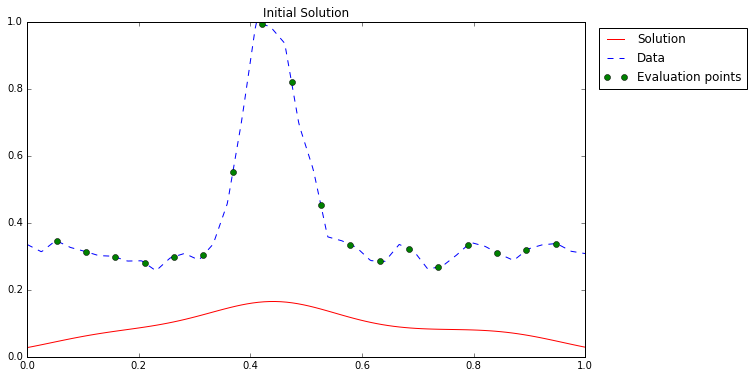

In [11]:
"""
Visualizing the 'initial' solution
"""
compare_plot(c0, sig0, xc, title='Initial Solution')

In [12]:
"""
Instantiating the EL func object and solving it!
"""
elf = ELFunc(f0, c0, sig0, xc, Dx)
sol = sp.optimize.fsolve(elf.F3, np.concatenate([elf.c, elf.sig]))
opt_c = sol[0:N]
opt_sig = sol[N:]
print(opt_c)
print(opt_sig)

[ -6.58809955e+00  -4.24120927e+00   1.40875921e+01  -1.72077206e+01
   1.15579016e+01   1.29892541e-02   2.55456342e-01   1.45075614e+01
   2.05988298e+00  -1.40479286e+01]
[   2.15384405    5.24879245    3.5339632     6.393036      5.24856127
  -62.20992109   -0.77964298 -173.56484747  157.47745702 -258.93298908]


/home/martin/miniconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


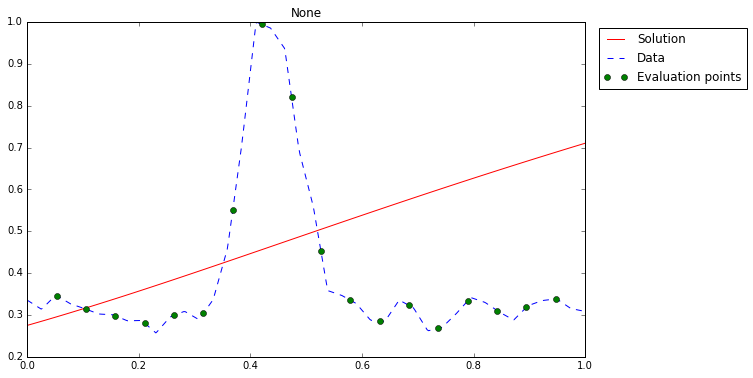

In [13]:
compare_plot(opt_c, opt_sig, xc)

## Variating $c$ and $\sigma$ separately

In [14]:
""" Computing center points """
xc = np.linspace(0., 1., N+2, endpoint=True)[1:-1]
print('Center points:')
print(xc)
print('----')

""" 
Computing evaluation points, i.e, points where
EL equation will be evaluated
"""
xe = np.linspace(0., 1., N, endpoint=True)[1:-1]
print('Evaluation points:')
print(xe)
print('----')

""" Computing the values of f at evaluation points """
f0 = f(xe)

""" 
Computing distance matrix.
Note: Evaluation and collocation points will be the same
"""
Dx = np.empty((N-2,N))
for k in range(N-2):
	Dx[k,:] = (xe[k] - xc)
    
#np.exp(-x**2/(2*sig0**2))
print Dx**2/(2*sig0**2)

Center points:
[ 0.09090909  0.18181818  0.27272727  0.36363636  0.45454545  0.54545455
  0.63636364  0.72727273  0.81818182  0.90909091]
----
Evaluation points:
[ 0.11111111  0.22222222  0.33333333  0.44444444  0.55555556  0.66666667
  0.77777778  0.88888889]
----
[[  2.04060810e-02   2.49974492e-01   1.30598918e+00   3.18845016e+00
    5.89735741e+00   9.43271095e+00   1.37945108e+01   1.89827569e+01
    2.49974492e+01   3.18385879e+01]
 [  8.62156923e-01   8.16243240e-02   1.27538006e-01   9.99897970e-01
    2.69870421e+00   5.22395674e+00   8.57565555e+00   1.27538006e+01
    1.77583920e+01   2.35894297e+01]
 [  2.93847567e+00   1.14784206e+00   1.83654729e-01   4.59136823e-02
    7.34618916e-01   2.24977043e+00   4.59136823e+00   7.75941230e+00
    1.17539027e+01   1.65748393e+01]
 [  6.24936231e+00   3.44862769e+00   1.47433935e+00   3.26497296e-01
    5.10152025e-03   5.10152025e-01   1.84164881e+00   3.99959188e+00
    6.98398123e+00   1.07948169e+01]
 [  1.07948169e+01   6.983

In [15]:
""" Computing center points """
xc = np.linspace(0., 1., N+2, endpoint=True)[1:-1]
print('Center points:')
print(np.sort(xc))
print('----')

""" 
Computing evaluation points, i.e, points where
EL equation will be evaluated
"""
xe = np.linspace(0., 1., 2*N, endpoint=True)[1:-1]
print('Evaluation points:')
print(np.sort(xe))
print('----')

""" Computing the values of f at evaluation points """
f0 = f(xe)

""" 
Computing distance matrix.
Note: Evaluation and collocation points will be the same
"""
Dx = np.empty((2*N-2,N))
for k in range(2*N-2):
	Dx[k,:] = (xe[k] - xc)


Center points:
[ 0.09090909  0.18181818  0.27272727  0.36363636  0.45454545  0.54545455
  0.63636364  0.72727273  0.81818182  0.90909091]
----
Evaluation points:
[ 0.05263158  0.10526316  0.15789474  0.21052632  0.26315789  0.31578947
  0.36842105  0.42105263  0.47368421  0.52631579  0.57894737  0.63157895
  0.68421053  0.73684211  0.78947368  0.84210526  0.89473684  0.94736842]
----


In [16]:
"""
Defining initial parameter values
"""
c0 = f(xc)/N
sig0 = (1./(N))*np.ones(N)
print(sig0)

[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]


In [17]:
elf = ELFunc(f0, c0, sig0, xc, Dx)
print(np.abs(elf.Dx).max())

0.856459330144


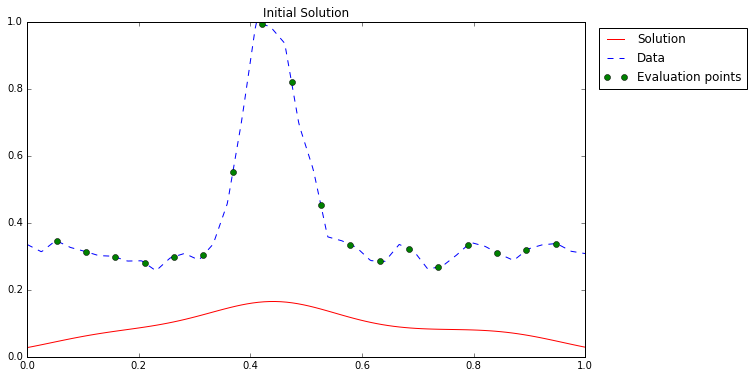

In [18]:
"""
Visualizing the 'initial' solution
"""
compare_plot(c0, sig0, elf.xc, title='Initial Solution')

In [19]:
"""
Instantiating the EL func object
"""
elf = ELFunc(f0, c0, sig0, xc, Dx)

In [20]:
#computing the Euler-Lagrange equation
c = np.array([ -1.31647136,    1.84909248  ,  1.56619835  , -4.30294614  ,  6.53202142 ,
  -15.11335347 ,  70.74992491, -321.25619084 , 351.43444242 , -89.76482507])
print c.shape
print elf.phi_m
u   = np.dot(elf.phi_m, c)
el  = (u-f0)

print u
print el

(10,)
[[  9.29360656e-01   4.34109307e-01   8.87345703e-02   7.93716750e-03
    3.10682779e-04   5.32166776e-06   3.98893788e-08   1.30841565e-10
    1.87807585e-13   1.17966710e-16]
 [  9.89750922e-01   7.45997086e-01   2.46052220e-01   3.55137380e-02
    2.24307825e-03   6.19971040e-05   7.49855053e-07   3.96882713e-09
    9.19233796e-12   9.31684186e-15]
 [  7.99032356e-01   9.71789015e-01   5.17200035e-01   1.20454782e-01
    1.22763281e-02   5.47509764e-04   1.06854838e-05   9.12589471e-08
    3.41063824e-10   5.57795236e-13]
 [  4.88989616e-01   9.59629652e-01   8.24112728e-01   3.09705220e-01
    5.09318403e-02   3.66529685e-03   1.15427125e-04   1.59068998e-06
    9.59272844e-09   2.53149863e-11]
 [  2.26846314e-01   7.18343476e-01   9.95431816e-01   6.03628621e-01
    1.60179550e-01   1.86004417e-02   9.45188406e-04   2.10180516e-05
    2.04524558e-07   8.70918293e-10]
 [  7.97738655e-02   4.07621858e-01   9.11450805e-01   8.91842043e-01
    3.81875320e-01   7.15540436e-02   5

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.56762047 -0.66203009  1.32802273 -1.99772818  3.40851414 -2.63275347
  1.90582209 -0.82563159  0.38226417  0.22692248]


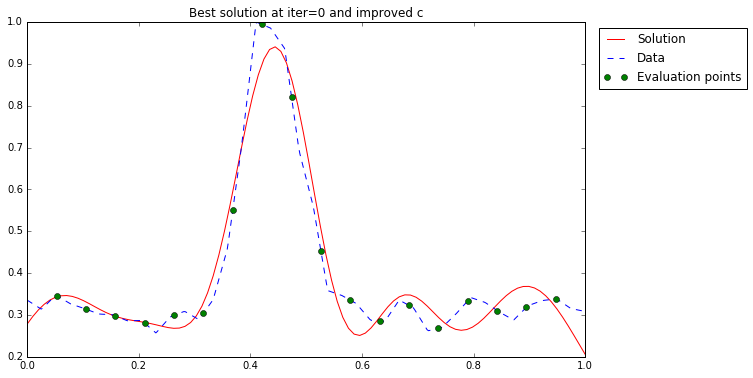

0.0124687205891
Variation on c=5.39923353321
------------------------------------------------------------


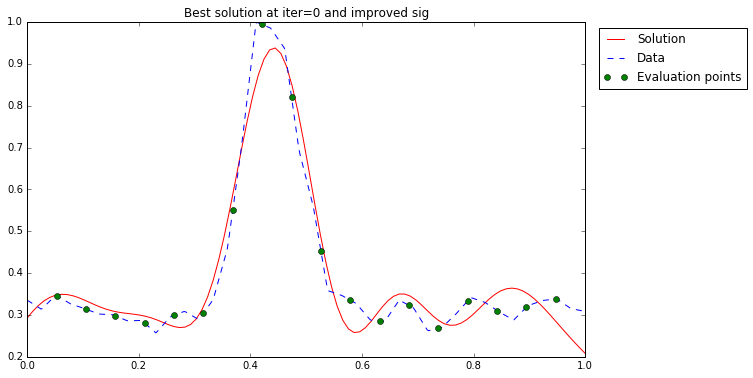

Variation on sig=0.0519390506638
-------------------------------------------------------------
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.57147295 -0.6729486   1.30683903 -1.93549791  3.31152947 -2.49061871
  1.75264475 -0.71947738  0.2655546   0.28975916]


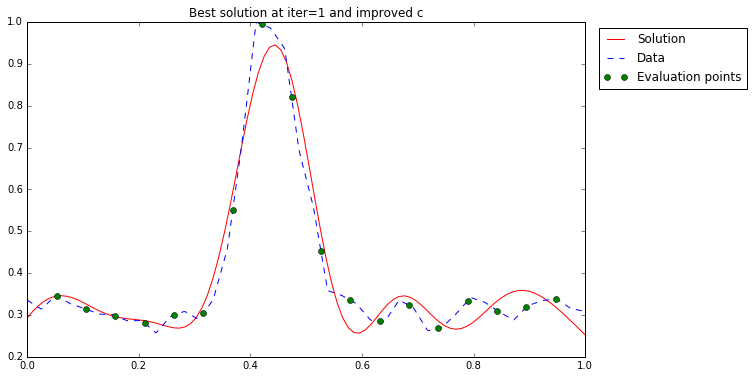

0.0106576639786
Variation on c=0.2938797561
------------------------------------------------------------


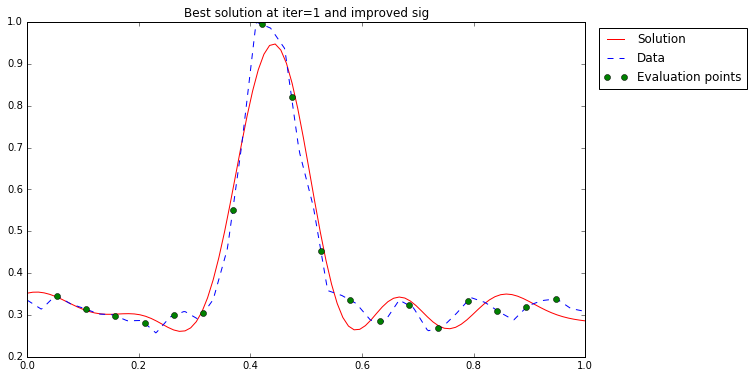

Variation on sig=0.381437001434
-------------------------------------------------------------
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.55546594 -0.65085308  1.26607123 -1.89288748  3.24894174 -2.43909138
  1.69203402 -0.69339118  0.23400828  0.30832994]


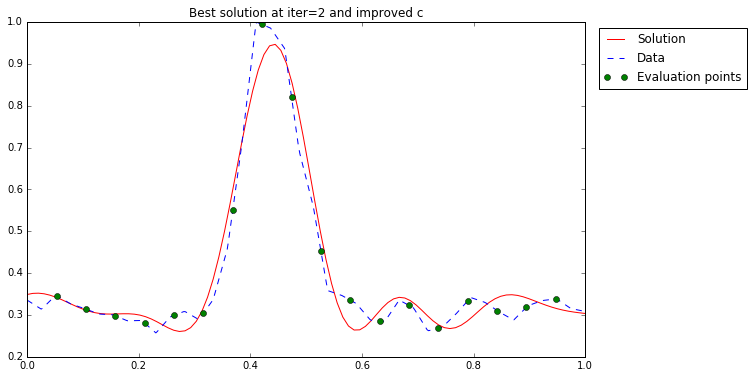

0.00908703680026
Variation on c=0.128407887616
------------------------------------------------------------


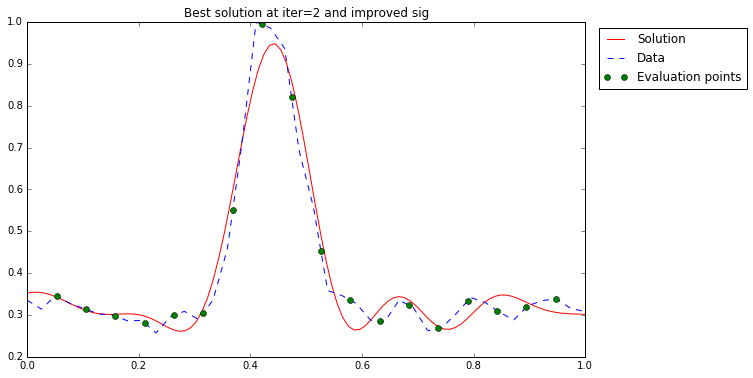

Variation on sig=0.0444929027101
-------------------------------------------------------------
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.54226449 -0.63314641  1.23655286 -1.8637629   3.20845889 -2.40868161
  1.65743561 -0.68084824  0.21628586  0.31984317]


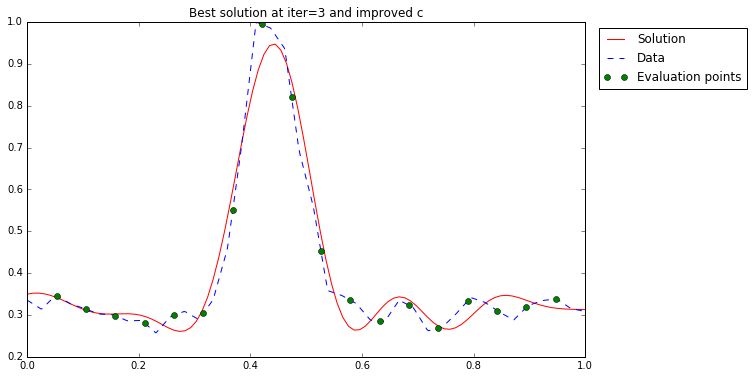

0.00897801327063
Variation on c=0.0810679221569
------------------------------------------------------------


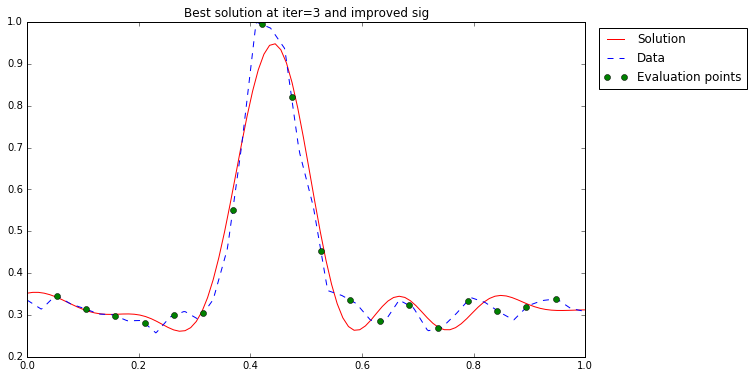

Variation on sig=0.0276687245032
-------------------------------------------------------------
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.53175568 -0.61871625  1.21450592 -1.84277336  3.18160321 -2.39047767
  1.6380373  -0.67524031  0.20681767  0.32674751]


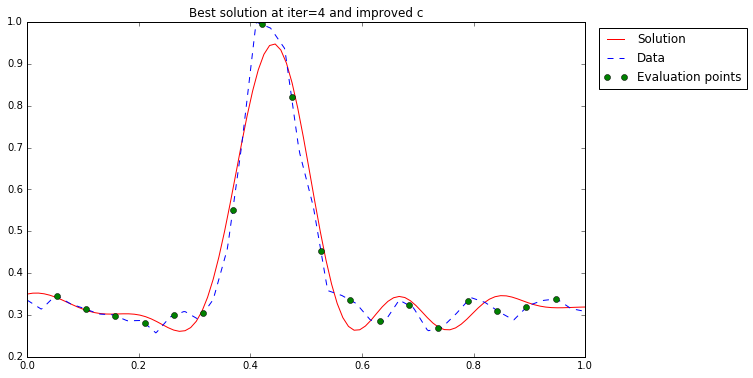

0.00896523477614
Variation on c=0.0533194499036
------------------------------------------------------------


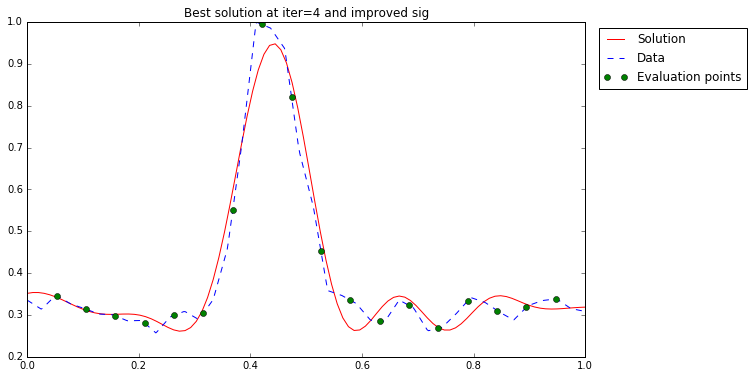

Variation on sig=0.0163615970593
-------------------------------------------------------------


In [21]:
"""
Solve it!
"""
n_iter = 5

for i in range(n_iter):
    #solve for c
    sol = sp.optimize.root(elf.F1, elf.c, method='lm')
    #print(sol)
    #print(elf.c.shape); print(elf.F1(elf.c).shape); print(sol.fun.shape)
    opt_c = sol.x
    print(sol.fun - elf.F1(opt_c))
    delta_c = np.linalg.norm(opt_c-elf.c)
    print(opt_c)
    elf.set_c(opt_c)
    title = 'Best solution at iter={0} and improved c'.format(i)
    compare_plot(elf.c, elf.sig, elf.xc, title=title)
    print(np.linalg.norm(0.25*elf.F1(elf.c)**2))
    print('Variation on c='+str(delta_c))
    print('------------------------------------------------------------')
    
    #solve for sig
    sol = sp.optimize.root(elf.F2, elf.sig, method='lm')
    #print(sol)
    opt_sig = sol.x
    delta_sig = np.linalg.norm(opt_sig-elf.sig)
    elf.set_sig(opt_sig)
    title = 'Best solution at iter={0} and improved sig'.format(i)
    compare_plot(elf.c, elf.sig, elf.xc, title=title)
    print('Variation on sig='+str(delta_sig))
    print('-------------------------------------------------------------')

TODO (last season):
- try different bc
- study 2 gaussians case
- try solver: min |F|
- study well posedeness of the problem

- ver diferencias entre f y el
- separa dos versiones
- $\sigma_i^2 = \sigma_0^2 + \widehat{\sigma}_i^2$

IDEAS:
* Other methods for solving the ODE/PDE: FEM, Spectral Methods, ...
* Change evaluation points at each iteration
* Define good function $\Psi_1$ and $\Psi_2$